In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn import preprocessing
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, homogeneity_score, silhouette_score, classification_report
from sklearn.mixture import GaussianMixture
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, train_test_split, learning_curve
import warnings
warnings.filterwarnings("ignore")
import time
from matplotlib.colors import LinearSegmentedColormap

In [17]:
dataset_select =     0    # 0 for wine , 1 for cancer

In [18]:
if dataset_select == 0:
    wine = pd.read_csv('data/wine.csv',sep=';')
    print('Wine Quality Dataset')
    print(wine.shape)
    bins = (2, 6.5, 8)
    group_names = ['bad','good']
    wine['quality'] = pd.cut(wine['quality'], bins=bins,labels=group_names)
    wine = wine.dropna()
    wine_label_quality = LabelEncoder()
    wine['quality'] = wine_label_quality.fit_transform(wine['quality'])
    df = wine
    X = wine.drop('quality',axis=1)
    y = wine['quality']
    dataset='wine'
elif dataset_select == 1:
    print('Cancer Dataset')
    cancer = pd.read_csv('data/cancer.csv')
    print(cancer.shape)
    cancer = cancer.dropna()
    cancer['class']=cancer['class'].map({4:1, 2:0})
    df = cancer
    X = cancer.drop(['id','class'],axis=1)
    y = cancer['class'] 
    dataset='Cancer'
else:
    raise Exception('dataset_select field must be 0 for wine , 1 for cancer')

X = MinMaxScaler().fit_transform(X)

Wine Quality Dataset
(4898, 12)


In [19]:
pca_7 = PCA(n_components=0.95, random_state=44)
pca_7.fit(X)
X_pca_7 = pca_7.transform(X)
var = (np.cumsum(pca_7.explained_variance_ratio_)*100)
comp = np.arange(1, pca_7.n_components_+1,1)
print(var)

[38.1228202  55.98411885 68.89254031 77.49406664 84.33856495 88.93077163
 92.85741146 96.18185553]


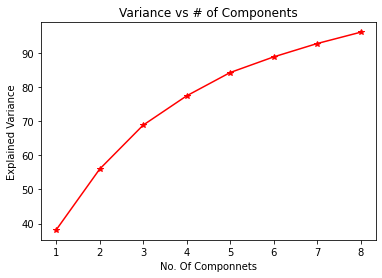

In [20]:
plt.plot(comp, var,'*-', color='r')
plt.xlabel('No. Of Componnets')
plt.ylabel('Explained Variance')
plt.title('Variance vs # of Components')
plt.savefig('img/PCA variance '+dataset+'.png')
plt.show()

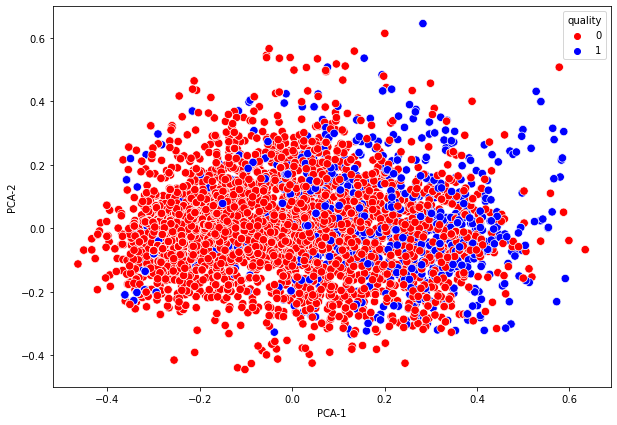

In [21]:
plt.figure(figsize=(10,7))
sns.scatterplot(x=X_pca_7[:, 0], y=X_pca_7[:,1], s = 70,
                hue=y, palette=['red','blue'])
plt.xlabel('PCA-1')
plt.ylabel('PCA-2')
plt.savefig('img/2d PCA clusters '+dataset+'.png')
plt.show()

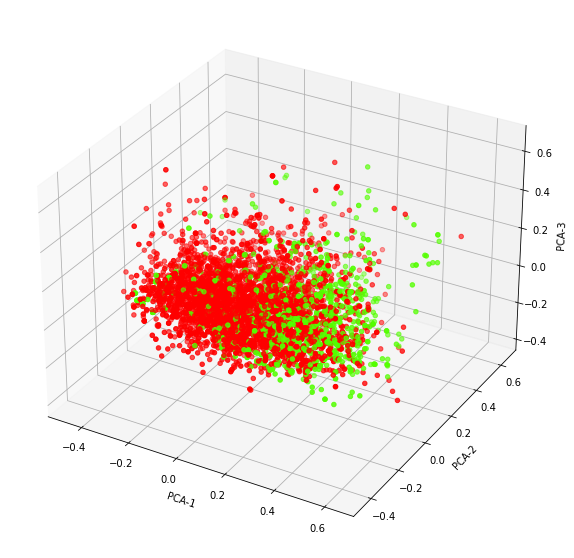

In [22]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=X_pca_7[:, 0], 
    ys=X_pca_7[:, 1], 
    zs=X_pca_7[:, 2], 
    c=y, 
    cmap='prism'
)
ax.set_xlabel('PCA-1')
ax.set_ylabel('PCA-2')
ax.set_zlabel('PCA-3')
plt.savefig('img/3d PCA clusters '+dataset+'.png')
plt.show()


In [8]:
N = np.arange(2, 41, 1)
S,H = [],[]
for n in N:
    km = KMeans(n_clusters=n,
                    n_init=50,
                    max_iter=1000,
                    random_state=44).fit(X_pca_7)
    S.append(silhouette_score(X, km.labels_, metric='euclidean'))
    H.append(homogeneity_score(y, km.labels_))

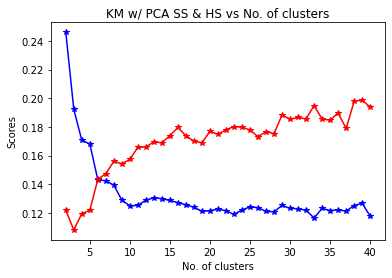

In [9]:
plt.figure()
plt.plot(N, S, '*-',color='b',label='Silhouette')
plt.plot(N, H, '*-',color='r',label='Homogeneity')
plt.title('')
plt.xlabel('No. of clusters')
plt.ylabel('Scores')
plt.title('KM w/ PCA SS & HS vs No. of clusters')
plt.savefig('img/KM PCA Scores '+dataset+'.png')
plt.show()

In [23]:
S, H, L = [],[],[]
for n in N:
    gmm = GaussianMixture(n_components=n,
                          max_iter=100,
                          random_state=44, 
                          n_init=5).fit(X_pca_7)
    l = gmm.predict(X_pca_7)
    S.append(silhouette_score(X, l, metric='euclidean'))
    H.append(homogeneity_score(y, l))
    L.append(gmm.score(X_pca_7))

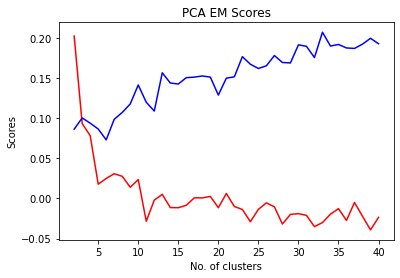

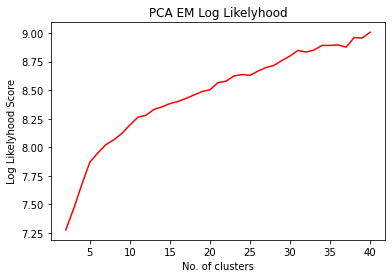

In [24]:
plt.figure()
plt.plot(N, S, color='r')
plt.plot(N, H, color='b')
plt.title('PCA EM Scores')
plt.xlabel('No. of clusters')
plt.ylabel('Scores')
plt.savefig('img/KM PCA Scores '+dataset+'.png')
plt.show()

plt.figure()
plt.plot(N, L, color='r')
plt.title('PCA EM Log Likelyhood')
plt.xlabel('No. of clusters')
plt.ylabel('Log Likelyhood Score')
plt.savefig('img/EM PCA log '+dataset+'.png')
plt.show()

Run Time:
3.497292995452881
Tuned Accuracy: 81.47%
[learning_curve] Training set sizes: [ 274  548  822 1096 1370 1644 1918 2192 2466 2740]


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  17 out of  50 | elapsed:   18.5s remaining:   35.9s
[Parallel(n_jobs=2)]: Done  34 out of  50 | elapsed:   37.5s remaining:   17.6s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:   58.2s finished


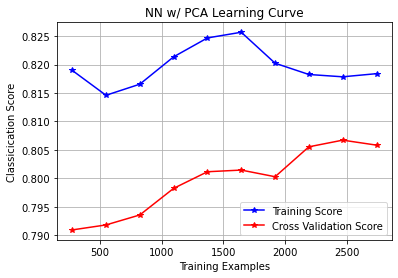

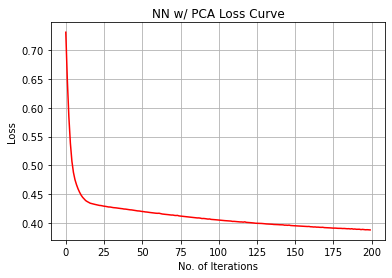

In [15]:
if dataset_select == 0:
    X_train, X_test, y_train, y_test = train_test_split(X_pca_7, 
                                                        y, 
                                                        test_size=0.3, 
                                                        random_state=42,
                                                        stratify=y)
    nn_clf = MLPClassifier()
    st = time.time()
    nn_clf.fit(X_train, y_train)
    print('Run Time:')
    print(time.time()-st)
    nn_y_pred = nn_clf.predict(X_test)
    nn_acc = accuracy_score(y_test, nn_y_pred)*100
    print("Tuned Accuracy: %.2f%%"%nn_acc)
    
    train_sizes, nn_train_scores, test_scores = learning_curve(nn_clf,
                                                               X_train,
                                                               y_train,
                                                               train_sizes=np.linspace(0.1,1.0,10),
                                                               verbose=3,
                                                               n_jobs=2)
    plt.figure()
    plt.plot(train_sizes, np.mean(nn_train_scores, axis=1),'*-',
            label='Training Score',color='blue')
    plt.plot(train_sizes, np.mean(test_scores, axis=1), '*-',
            label='Cross Validation Score',color='red')
    plt.title('NN w/ PCA Learning Curve')
    plt.xlabel('Training Examples')
    plt.ylabel('Classicication Score')
    plt.legend()
    plt.grid()
    plt.savefig('img/PCA_NN_learning '+dataset+'.png')
    plt.show()
    nn_loss= nn_clf.loss_curve_
    plt.figure()
    plt.title('NN w/ PCA Loss Curve')
    plt.xlabel('No. of Iterations')
    plt.ylabel('Loss')
    plt.plot(nn_loss, '-', color='red')
    plt.grid()

    plt.savefig('img/PCA_NN_loss '+dataset+'.png')
    plt.show()